In [1]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [49]:
import pathlib
from collections import Counter

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [3]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32 
VOCAB_SIZE = 6000
UNITS = 256

In [4]:
df = pd.read_csv("data/data.csv", sep = '\t')

df

,English,Vietnamese
0,Run!,Chạy!
1,Run!,Chạy đi!
2,Help!,Giúp tôi với!
3,Help!,Cứu tôi!
4,Jump!,Nhảy đi!
...,...,...
263513,What sound does a sheep make?,một con cừu tạo ra âm thanh gì?
263514,Tom stayed in Boston for three months.,Tom ở lại boston trong ba tháng.
263515,Tom borrowed $300 from Mary,tom đã vay $ 300 từ mary
263516,Why aren't you interested?,tại sao bạn không quan tâm?


In [5]:
context = df["English"]
target = df["Vietnamese"]

context_train, context_val, target_train, target_val = train_test_split(context, target, test_size = 0.2, random_state = 42)
train_raw = (
    tf.data.Dataset.from_tensor_slices((context_train, target_train))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)
val_raw = (
    tf.data.Dataset.from_tensor_slices((context_val, target_val))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

I0000 00:00:1747901096.574577  153144 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2146 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
def clean(text):
    # text = tf.strings.lower(text)
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, "[^a-zA-ZÀ-ỹà-ỹ?.,! ]", '')  # keep Vietnamese words
    text = tf.strings.regex_replace(text, "[?.,!]", r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.join(["[SOS]", text, "[EOS]"], separator=" ")
    return text

In [7]:
example_vie = "Bí mật của cuộc sống là ngã bảy lần và đứng dậy tám lần – trích Nhà Giả Kim | Paulo Coelho"
ex_vie_out = clean(example_vie)
decoded_ex_vie_out = ex_vie_out.numpy().decode()
print("Example sentence")
print(example_vie,'\n')

print("Example cleaned of example sentence (Not decoded)")
print(ex_vie_out, '\n')
print("Decoded")
print(decoded_ex_vie_out)

Example sentence
Bí mật của cuộc sống là ngã bảy lần và đứng dậy tám lần – trích Nhà Giả Kim | Paulo Coelho 

Example cleaned of example sentence (Not decoded)
tf.Tensor(b'[SOS] b\xc3\xad m\xe1\xba\xadt c\xe1\xbb\xa7a cu\xe1\xbb\x99c s\xe1\xbb\x91ng l\xc3\xa0 ng\xc3\xa3 b\xe1\xba\xa3y l\xe1\xba\xa7n v\xc3\xa0 \xc4\x91\xe1\xbb\xa9ng d\xe1\xba\xady t\xc3\xa1m l\xe1\xba\xa7n  tr\xc3\xadch nh\xc3\xa0 gi\xe1\xba\xa3 kim  paulo coelho [EOS]', shape=(), dtype=string) 

Decoded
[SOS] bí mật của cuộc sống là ngã bảy lần và đứng dậy tám lần  trích nhà giả kim  paulo coelho [EOS]


In [8]:
eng_vectorizer = tf.keras.layers.TextVectorization(standardize = clean,
                                                   max_tokens = VOCAB_SIZE,
                                                   ragged = True)
eng_vectorizer.adapt(train_raw.map(lambda context, target: context))

vie_vectorizer = tf.keras.layers.TextVectorization(standardize = clean,
                                                   max_tokens = VOCAB_SIZE,
                                                   ragged = True)
vie_vectorizer.adapt(train_raw.map(lambda context, target: target))

In [9]:
print(vie_vectorizer.get_vocabulary()[:20])
vie_vectorizer.vocabulary_size()

['', '[UNK]', '[SOS]', '[EOS]', 'tôi', '.', 'bạn', 'không', 'tom', 'có', 'một', 'đã', 'anh', 'của', 'là', '?', 'ấy', 'chúng', 'sẽ', 'thể']


6000

In [10]:
print(eng_vectorizer.get_vocabulary()[:20])
eng_vectorizer.vocabulary_size()

['', '[UNK]', '[SOS]', '[EOS]', '.', 'to', 'the', 'i', 'tom', 'you', 'a', '?', 'is', 'he', 'in', 'of', 'that', ',', 'was', 'it']


6000

In [11]:
eng_vectorizer(["Hello who are you"])

<tf.RaggedTensor [[2, 1706, 100, 36, 9, 3]]>

In [12]:
eng_word2id = tf.keras.layers.StringLookup(
    vocabulary = eng_vectorizer.get_vocabulary(),
    mask_token = '',
    oov_token = "[UNK]"
)

eng_id2word = tf.keras.layers.StringLookup(
    vocabulary = eng_vectorizer.get_vocabulary(),
    mask_token = '',
    oov_token = "[UNK]",
    invert = True
)

vie_id2word = tf.keras.layers.StringLookup(
    vocabulary = vie_vectorizer.get_vocabulary(),
    mask_token = '',
    oov_token = "[UNK]",
    invert = True
)

vie_id2word = tf.keras.layers.StringLookup(
    vocabulary = vie_vectorizer.get_vocabulary(),
    mask_token = '',
    oov_token = "[UNK]",
    invert = True
)

print(eng_word2id("[UNK]"))
print(eng_word2id("jump"))

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1828, shape=(), dtype=int64)


In [13]:
def process_text(context, target):
    context = eng_vectorizer(context).to_tensor()
    target = vie_vectorizer(target)
    # Use the current word to predict the next word
    target_in = target[:, :-1].to_tensor()
    target_out = target[:, 1:].to_tensor()
    return (context, target_in), target_out

In [14]:
for _ in train_raw.take(1):
    context, output = _ 
    print(context[0])
    print(output[0])

tf.Tensor(b"If it's not one thing, it's another.", shape=(), dtype=string)
tf.Tensor(b'n\xe1\xba\xbfu n\xc3\xb3 kh\xc3\xb4ng ph\xe1\xba\xa3i l\xc3\xa0 m\xe1\xbb\x99t th\xe1\xbb\xa9, n\xc3\xb3 l\xc3\xa0 m\xe1\xbb\x99t th\xe1\xbb\xa9 kh\xc3\xa1c.', shape=(), dtype=string)


In [15]:
train_data = train_raw.map(process_text, tf.data.AUTOTUNE)
val_data = val_raw.map(process_text, tf.data.AUTOTUNE)

In [16]:
for _ in train_data.take(1):
    a, b = _
    a1, a2 = a 
    print(a1.shape)
    print(a2.shape)
    print(b.shape)
    print(a1[0])

(32, 17)
(32, 17)
(32, 17)
tf.Tensor([  2   8 368  13 236   5  24   6 282 249   7  65  14 132   4   3   0], shape=(17,), dtype=int64)


In [17]:
def vect_to_text(vect, id2word):
    """
    Convert from vector of ids into the corresponding text

    Args:
        vect (tf.Tensor): include id of words in the sequence
        id2word (tf.keras.layers.StringLookup): invert string lookup for convert id to word

    Returns:
        str: the converted texts
    """
    words = id2word(vect)
    no_pad = tf.boolean_mask(words, words != b'')
    text = tf.strings.reduce_join(no_pad, separator = ' ')
    return text.numpy().decode()

In [18]:
for x in train_data.take(1):
    (context, target_in), target_out = x
    train_context0 = context[0]
    target_in0 = target_in[0]
    target_out0 = target_out[0]
    
    print(train_context0)
    print(vect_to_text(train_context0, eng_id2word), '\n')
    print(target_in0)
    print(vect_to_text(target_in0, vie_id2word), '\n')
    print(target_out0)
    print(vect_to_text(target_out0, vie_id2word), '\n')

tf.Tensor([  2  40   6  59  17  19 836  42   6 125 249   5  24   4   3], shape=(15,), dtype=int64)
[SOS] at the time , it seemed like the right thing to do . [EOS] 

tf.Tensor(
[   2   82   96  403   21   26   41    9  200   59   14   39  244 1726
   38   20    5], shape=(17,), dtype=int64)
[SOS] tại thời điểm đó , nó có vẻ như là điều đúng đắn để làm . 

tf.Tensor(
[  82   96  403   21   26   41    9  200   59   14   39  244 1726   38
   20    5    3], shape=(17,), dtype=int64)
tại thời điểm đó , nó có vẻ như là điều đúng đắn để làm . [EOS] 



In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, units, vocab_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(
            input_dim = vocab_size, 
            output_dim = units, 
            mask_zero = True
        )
        self.rnn = tf.keras.layers.LSTM(
            units = units,
            return_sequences = True, 
        )
        
    def call(self, context):
        """
        Forward pass of this layer

        Args:
            context (tf.Tensor) : The sentences to translate (B, L) 
            
        Returns:
            tf.Tensor: (B, L, D): Encoded sentence to tranlsate
        """
        x = self.embedding(context)
        x = self.rnn(x)
        return x

In [20]:
encoder = Encoder(UNITS, VOCAB_SIZE)
encoder_output = encoder(context)

print(context.shape)
print(encoder_output.shape)

(32, 15)
(32, 15, 256)


I0000 00:00:1747901132.334363  153224 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [21]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(
            key_dim = units,
            num_heads = 1
        )
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        
    def call(self, context, target):
        """Forward pass of Attention

        Args:
            context (tf.Tensor): (B, L1, D) encoded setence to translate
            target (tf.Tensor): (B, L2, D) right shifted translation 
            
        Return:
            tf.Tensor: (B, L2, D) cross attention between context and target
        """
        # query is the translation and the value is the context 
        # default key = value 
        attn_output = self.mha(
            query = target,
            value = context
        )
        x = self.add([target, attn_output])
        x = self.layernorm(x)
        return x     

In [22]:
attn = CrossAttention(UNITS)
attn_result = attn(
    encoder_output,
    tf.keras.layers.Embedding(input_dim = VOCAB_SIZE, output_dim = UNITS, mask_zero = True)(target_out)
)

print(attn_result.shape)

/home/vz/miniconda3/envs/cu118/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/vz/miniconda3/envs/cu118/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/vz/miniconda3/envs/cu118/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.

(32, 17, 256)


/home/vz/miniconda3/envs/cu118/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'cross_attention' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [23]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, units, vocab_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(
            input_dim = vocab_size,
            output_dim = units, 
            mask_zero = True
        )
        self.pre_attn_rnn = tf.keras.layers.LSTM(
            units = units, 
            return_sequences = True,
            return_state = True 
        )
        self.attention = CrossAttention(units)
        self.post_attn_rnn = tf.keras.layers.LSTM(
            units = units, 
            return_sequences = True
        )
        self.dense = tf.keras.layers.Dense(
            units = vocab_size, 
            activation = "log_softmax"
        )
    def call(self,
             context,
             target,
             state = None,
             return_state = False):
        """Forwardpass of Decodeer

        Args:
            context (tf.Tensor): (B, L1, D) encoded sentence to translate 
            target (tf.Tensor): (B, L1) the right-shited translation 
            state (list([tf.Tensor, tf.Tensor]), optional): Hidden state of the pre-attn RNN. Defaults to None.
            return_state (bool, optional): Return state of pre-attn LSTM. Defaults to False.
        """
        x = self.embedding(target)
        
        x, h, c = self.pre_attn_rnn(
            x, 
            initial_state = state
        )
        
        x = self.attention(context, x)
        x = self.post_attn_rnn(x)
        logits = self.dense(x)
        
        if return_state: return logits, [h, c]
        return logits

In [24]:
decoder = Decoder(UNITS, VOCAB_SIZE)
logits = decoder(encoder_output, target_out)

logits.shape

/home/vz/miniconda3/envs/cu118/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'cross_attention_1' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/vz/miniconda3/envs/cu118/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'decoder' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


TensorShape([32, 17, 6000])

In [25]:
class Translator(tf.keras.Model):
    def __init__(self, units, vocab_size):
        super().__init__()
        self.encoder = Encoder(units, vocab_size)
        self.decoder = Decoder(units, vocab_size)
    def call(self, inputs):
        """Forward pass of the model

        Args:
            inputs (tuple(tf.Tensor, tf.Tensor)): (2, B, L) Tuple of context and target 
        
        Returns:
            tf.Tensor: (B, L2, V) log_softmax probabilites of predict a particular token
        """
        context, target = inputs 
        encoded_context = self.encoder(context)
        logits = self.decoder(encoded_context, target)
        return logits

In [26]:
translator = Translator(UNITS, VOCAB_SIZE)
logits = translator((context, target_in))
logits.shape

/home/vz/miniconda3/envs/cu118/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/vz/miniconda3/envs/cu118/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


TensorShape([32, 17, 6000])

In [27]:
def masked_loss(y_true, y_pred):
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)
    
    # Check which elements of y_true are padding
    mask = tf.cast(y_true != 0, loss.dtype)
    
    loss *= mask
    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)


def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    match*= mask

    return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [28]:
translator.compile(
    optimizer = "Adam",
    loss = masked_loss,
    metrics = [masked_acc, masked_loss]
)

translator.summary()

Model: "translator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)             │ ?                      │     2,061,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │     4,392,304 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,453,616 (24.62 MB)

 Trainable params: 6,453,616 (24.62 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = translator.fit(
    train_data,
    epochs = 50,    
    validation_data = val_data,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3),
                 tf.keras.callbacks.TensorBoard(log_dir = "./logs")]
)

Epoch 1/50
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 257s 38ms/step - loss: 3.6633 - masked_acc: 0.3892 - masked_loss: 3.6633 - val_loss: 1.4309 - val_masked_acc: 0.7231 - val_masked_loss: 1.4309
Epoch 2/50
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 252s 38ms/step - loss: 1.3046 - masked_acc: 0.7411 - masked_loss: 1.3046 - val_loss: 1.1165 - val_masked_acc: 0.7710 - val_masked_loss: 1.1165
Epoch 3/50
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 251s 38ms/step - loss: 0.9959 - masked_acc: 0.7874 - masked_loss: 0.9959 - val_loss: 0.9955 - val_masked_acc: 0.7921 - val_masked_loss: 0.9955
Epoch 4/50
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 253s 38ms/step - loss: 0.8445 - masked_acc: 0.8121 - masked_loss: 0.8445 - val_loss: 0.9399 - val_masked_acc: 0.8023 - val_masked_loss: 0.9399
Epoch 5/50
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 258s 39ms/step - loss: 0.7458 - masked_acc: 0.8282 - masked_loss: 0.7458 - val_loss: 0.9103 - val_masked_acc: 0.8087 - val_masked_loss: 0.9103
Epoch 6/50
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 258s 39ms/step - loss: 0.6718 - m

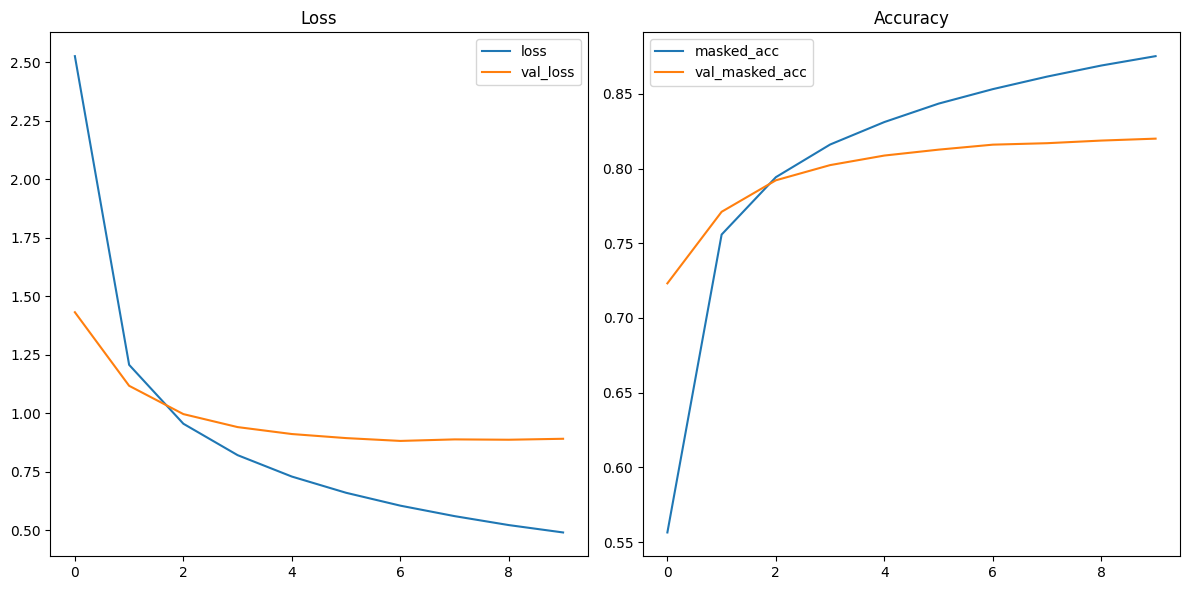

In [59]:
H = history.history
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

# Plot loss
sns.lineplot(H["loss"], ax=axes[0], label="loss")
sns.lineplot(H["val_loss"], ax=axes[0], label="val_loss")
axes[0].set_title("Loss")
axes[0].legend()  

# Plot accuracy
sns.lineplot(H["masked_acc"], ax=axes[1], label="masked_acc")
sns.lineplot(H["val_masked_acc"], ax=axes[1], label="val_masked_acc")
axes[1].set_title("Accuracy")
axes[1].legend()  

plt.tight_layout()
plt.show()


In [30]:
def generate_next_token(
    decoder,
    context, 
    next_token,
    state, 
    done, 
    temperature = 0.0
):
    # Get the logits and state from the decoder
    logits, state = decoder(context,
                            next_token,
                            state = state,
                            return_state = True)
    
    # Trim the intermediate dimension 
    logits = logits[:, -1, :]

    if temperature == 0.0: 
        next_token = tf.argmax(logits, axis = -1)
    else:
        logits = logits / temperature 
        next_token = tf.random.categorical(logits, num_samples=1)
    
    # Trim dimensions of size 1
    logits = tf.squeeze(logits)
    next_token = tf.squeeze(next_token)
    
    # Get the logit of the selected next_token
    logit = logits[next_token].numpy()
    
    # Reshape to (1,1) since this is the expected shape for text encoded as TF tensors
    next_token = tf.reshape(next_token, shape = (1, 1))
    
    # If next_token is End-of-Sentence token you are done
    if next_token == 3: # [EOS]
        done = True
    
    return next_token, logit, state, done

In [31]:
# PROCESS SENTENCE TO TRANSLATE AND ENCODE

# A sentence you wish to translate
eng_sentence = "I miss her"

# Convert it to a tensor
texts = tf.convert_to_tensor(eng_sentence)[tf.newaxis]

# Vectorize it and pass it through the encoder
context = eng_vectorizer(texts).to_tensor()
context = encoder(context)

# SET STATE OF THE DECODER
# Next token is Start-of-Sentence since you are starting fresh
next_token = tf.fill((1, 1), 2) #[SOS]

# Hidden and Cell states of the LSTM can be mocked using uniform samples
state = [tf.random.uniform((1, UNITS)), tf.random.uniform((1, UNITS))]
done = False 

next_token, logit, state, done = generate_next_token(decoder, context, next_token, state, done , temperature = 0.5)
print(f"Next token: {next_token}\nWord:{vie_id2word(next_token)}\nLogit: {logit:.4f}\nDone? {done}")


Next token: [[3609]]
Word:[[b'pablo']]
Logit: -17.4095
Done? False


In [32]:
def translate(model, 
              text, 
              max_length = 15,
              temperature = 0.0):
    """Translate a English sentence to Vietnamese

    Args:
        model (tf.keras.Model): The translator model
        text (str): The English context sentence
        max_length (int, optional): The maximum length of the translation. Defaults to 15.
        temperature (float, optional): Randomness of the translation. Defaults to 0.0.
    
    Returns:
        tuple(str, np.float, tf.Tensor): The translation, logit that predicted [EOS] token, and the tokenizeed translation
    """
    tokens, logits = list(), list()
    
    # convert the string to tensor
    text = tf.convert_to_tensor(text)[tf.newaxis]
    
    # vectorize the string tensor 
    context = eng_vectorizer(text).to_tensor()
    
    # get the encoded context
    context = model.encoder(context)
    

    # [SOS]
    next_token = tf.fill((1, 1), 2)
    
    # initial hidden states(h0) and cell states(c0) will be tensor of 0 with dim (1, UNITS)
    state = [tf.zeros((1, UNITS)), tf.zeros((1, UNITS))]
    
    # done flag 
    done = False 
    for i in range(max_length):
        try:
            next_token, logit, state, done = generate_next_token(
                decoder = model.decoder,
                context = context, 
                next_token = next_token,
                state = state, 
                done = done, 
                temperature = temperature
            )
        except:
            raise Exception("Problem generating the next token")

        # check done 
        if done:
            break 
            
        # append the result 
        tokens.append(next_token)
        logits.append(logit)

    # concatenate all token into a tensor 
    tokens = tf.concat(tokens, axis = - 1)
    
    # convert translated tokens to text
    translation = vect_to_text(tokens, vie_id2word)
    
    return translation, logits[-1], tokens

In [33]:
temp = 0.4
test_eng_sentence = "Please let me go"

translation, logit, tokens = translate(translator, test_eng_sentence, temperature = temp)


print(f"Temperature: {temp}")
print(f"Original sentence: {test_eng_sentence}")
print(f"Translation: {translation}")
print(f"Translation tokens:{tokens}")
print(f"Logit: {logit}")

Temperature: 0.4
Original sentence: Please let me go
Translation: xin vui lòng cho tôi đi
Translation tokens:[[162 122 180  25   4  32]]
Logit: -0.7238190770149231


In [34]:
def generate_samples(model, text, n_samples = 4, temperature = 0.6):
    """
    Generate n tranlsation for text

    Args:
        model (tf.keras.Model): The translate model
        text (str): The English context sentence
        n_samples (int, optional): Numer of samples need to be generated. Defaults to 4.
        temperature (float, optional): Randomess. Defaults to 0.6.

    Return: 
        tuple(list, float): list of setences (tokenized) and its log probs
    """
    samples, log_probs = list(), list()
    for _  in range(n_samples):
        translation, log_p, sample = translate(model, text, temperature = temperature)
        samples.append(np.squeeze(sample.numpy().tolist()))
        log_probs.append(log_p)
    return samples, log_probs

In [35]:
samples, log_probs = generate_samples(translator, test_eng_sentence)

for s, l in zip(samples, log_probs):
    print(f"Translated tensor: {s} has logit: {l:.3f}")

Translated tensor: [162 122 180  25   4  32] has logit: -0.483
Translated tensor: [162 122 180  25   4  32] has logit: -0.483
Translated tensor: [162 122 180  25   4  32] has logit: -0.483
Translated tensor: [162  25   4  32] has logit: -0.072


In [36]:
def rouge1_similarity(candidate, reference):
    """
    Compmute ROUGE1 score between 2 token lists

    Args:
        candidate (list[int]): Tokenized candidate translation
        reference (list[int]): Tokenized reference translation
    
    Return:
        float: Overlap between the two token lists
    """
    candiate_word_counts = Counter(candidate)
    reference_word_counts = Counter(reference) 
    overlap = 0
    
    for token in candidate: 
        can_token_count = candiate_word_counts[token]
        ref_token_count = reference_word_counts[token]
        overlap += min(ref_token_count, can_token_count)
    
    precision = overlap / sum(candiate_word_counts.values())
    recall = overlap / sum(reference_word_counts.values())
    
    f1_score = 0 # if precision + recall = 0 
    if precision + recall != 0 : 
        f1_score = 2 * precision * recall / (precision + recall)
    
    return f1_score

In [37]:
l1 = [1, 2, 3]
l2 = [1, 2, 3, 4]
print(rouge1_similarity(l1, l2))

0.8571428571428571


In [38]:
def average_overlap(samples):
    """
    Compute the mean of each candiate sentence in the samples

    Args:
        samples (list[list[int]]): Tokenized version of translated sentences
    
    Returns:
    list[float]: Scores at each index
    """
    n_samples = len(samples)
    scores = []
    for i1, c1 in enumerate(samples):
        s = 0 # save the current mean score
        for i2, c2 in enumerate(samples):
            if i2 == i1: continue 
            s += rouge1_similarity(c1, c2)
        
        # get average 
        s /= (n_samples - 1)
        
        # round to 3 decimal points 
        s = round(s, 3)
        
        # save to dict 
        scores.append(s)
    
    return scores
        

In [39]:
l1 = [1, 2, 3]
l2 = [1, 2, 4]
l3 = [1, 2, 4, 5]

print(average_overlap([l1, l2, l3]))

[0.619, 0.762, 0.714]


In [40]:
def weighted_avg_overlap(samples,
                         log_probs):
    """
    Compute the weighted average of each candidate sentence in samples

    Args:
        samples (list[list[int]]): Tokenized version of translated sentences
        log_probs (list[int]): log prob of each sentence
        
    Returns:
    list[float]: Scores at each index
    """
    n_samples = len(samples)
    scores = []
    for i1, c1 in enumerate(samples):
        s = 0 # save the current mean score
        
        for i2, (c2, c2_logp) in enumerate(zip(samples, log_probs)):
            if i2 == i1: continue 
            
            # convert log prob to linear scale 
            c2_p = float(np.exp(c2_logp))
            
            # compute score
            s += rouge1_similarity(c1, c2)
            
            # weight for it 
            s *= c2_p
        
        # get average 
        s /= (n_samples - 1)
        
        # round to 3 decimal points 
        s = round(s, 3)
        
        # save to dict 
        scores.append(s)
    
    return scores

In [41]:
l1 = [1, 2, 3]
l2 = [1, 2, 4]
l3 = [1, 2, 4, 5]
log_probs = [0.4, 0.2, 0.5]

print(weighted_avg_overlap([l1, l2, l3], log_probs))

[1.142, 1.526, 1.044]


In [42]:
def mbr_decode(model,
               text,
               n_samples = 5, 
               temperature = 0.6):
    # generatre samples
    samples, log_probs = generate_samples(model, text, n_samples, temperature)
    
    # compute scores
    scores = weighted_avg_overlap(samples, log_probs)
    
    # get the highest score translation 
    id = np.argmax(scores)
    translation = samples[id]
    
    return translation, samples

In [43]:
translation, candidates = mbr_decode(translator, test_eng_sentence, 5)
print("Context sentence")
print(test_eng_sentence, '\n')

print("Tranlsation candidates:")
for c in candidates:
    print(vect_to_text(c, vie_id2word))

print("\nSelected translation")
print(vect_to_text(translation, vie_id2word))

Context sentence
Please let me go 

Tranlsation candidates:
xin hãy cho tôi đi
xin vui lòng để tôi đi
xin vui lòng cho tôi đi
xin làm ơn để tôi đi phấn chai
xin vui lòng cho tôi đi

Selected translation
xin vui lòng cho tôi đi


In [ ]:
translator.save('./model/translator.keras')

In [61]:
import pickle

In [ ]:
with open("./model/eng_tokenizer.pkl", "wb") as f:
    pickle.dump(eng_vectorizer, f)
    
with open("./model/vie_tokenizer.pkl", "wb") as f:
    pickle.dump(vie_vectorizer, f)
    
with open("./model/vie_id2word.pkl", "wb") as f:
    pickle.dump(vie_id2word, f)